# DenseAutoencoder MNISTdataset

First of all, let's see a general introduction about Autoencoders, then we see an application on the MNIST dataset. 

## AUTOENCODERS

**An Autoencoder is a particular type of NNs, whose aim is to reconstruct back the input data out of an internal representation.**

An Autoencoder consists of two parts.

1. **Encoder**. It is a sequence of layers (i.e. it is a NN). It takes the input instance $x$ and it returns a lower-dimensional vector $z$, called **latent encoding**. It's the internal compressed representation of $x$ built by the encoder.
2. **Decoder**. It is a sequence of layers (i.e. it is a NN). It takes the latent encoding $z$ and it reconstructs back the original input instance $x$. It returns an approximation of the input instance: $\hat{x}$.

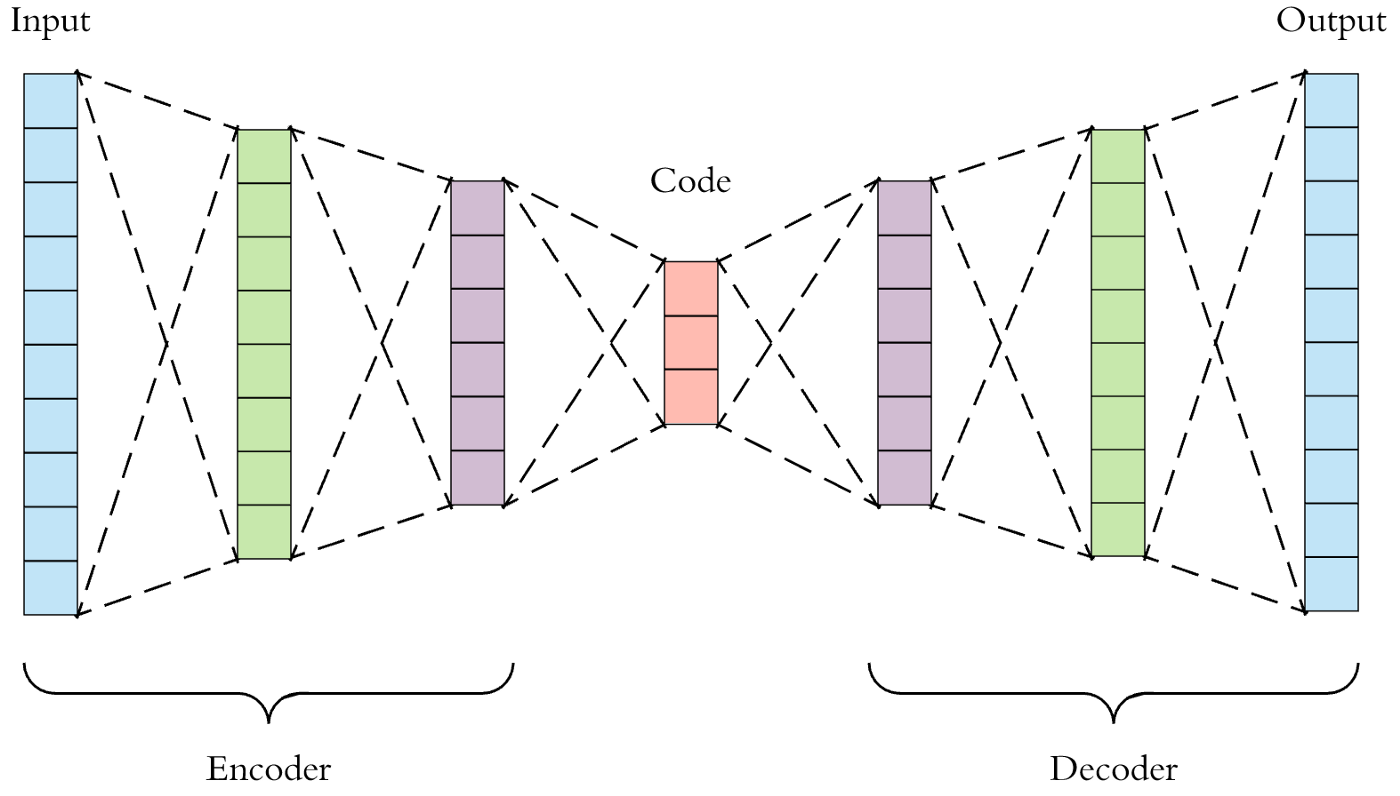

Basically, the Autoencoder learns how to encode the data $x$ into a low-dimensional vector $z$ which captures the semantic of the input. It learns how to encode the semantic of the input. With the aim to renstruct the input back out of this representation. 

The autoencoder task of reconstructing back the input $x$ is an **unsupervised task**: there is no supervision $y$.

The autoencoder can be a fully Dense NN or it can be a Conv NN, with Conv layers.

### Motivation

**Features space and data manifold**

The features space is the space of all the possible instances. Space of all the data. The data manifold instead is the subspace of the features spacw which contains only the interesting and meaningful data (interesting and meaningful for our task). It contains only the data which make sense for our task.

For example if we talk about images, the features space is the space of all possible images. More precisely, if the spatial dimensions are $28,28$, then the features space is $R^{784}$. The data manifold is the subspace containing only the images which make sense for humans. Which have a meanining, from the humans point of view.

Example of manifold for the MNIST dataset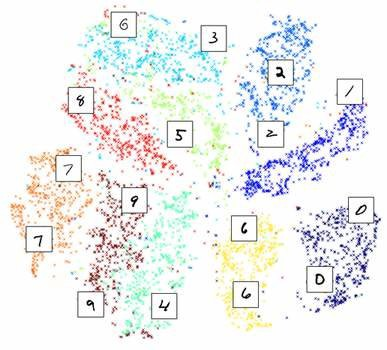

The data manifold has two interesting properties.
1. It has a very small dimensionality with respect to the features space. It is very small, with respect to the whole features space. This means that, if we generate an image randomly, the probability that this image belongs to the data manifold is basically $0$.
2. The data manifold has a sort of continuity. There is continuity between the images which have a meanining: from an image with a meanining, I can obtain another image with a meanining, by simply performing a small transformation.

Example of low dimensionality. The features space has two dimensions, while the data manifold only one. 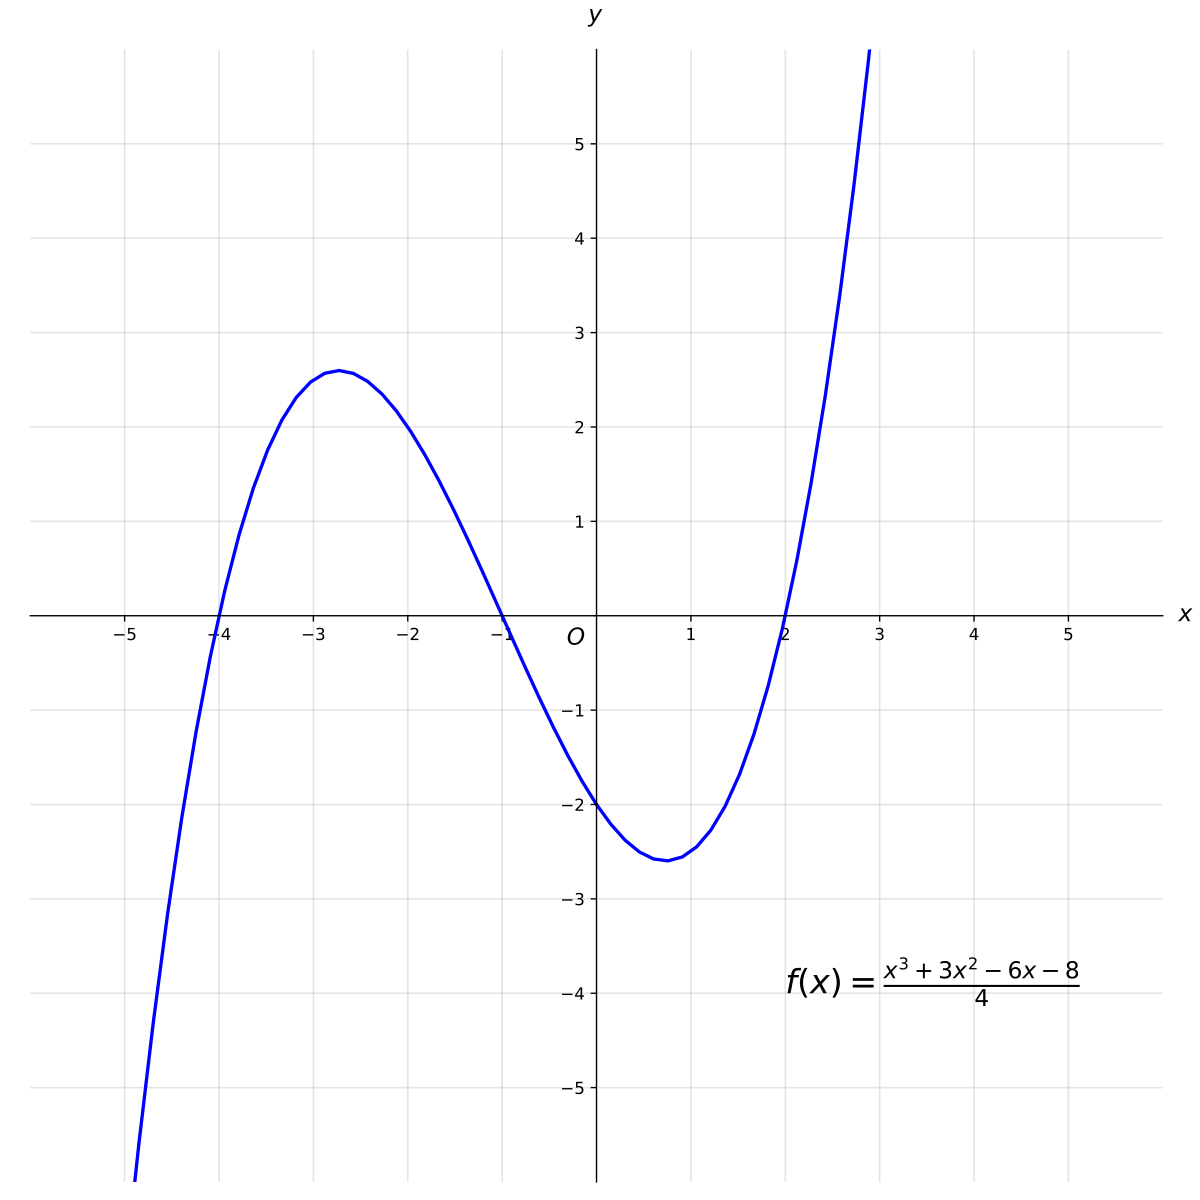

**Autoencoder and latent space**

So, if it is True that the data manifold has much smaller dimensions, we could try to compress our data using less dimensions. The Autoencoder try to learn how to encode the data into a low-dimensional representation, which captures the semantic how the data. And it does that by trying to reconstruct back the input data.

The encoding produced by the Autoencoder is called latent encoding. The space of all the latent encodings is called latent space.

### Unsupervised learning

The Autoencoder task is an unsupervised task. We have only the data $x$, without the supervision $y$.

In the training phase, we train the NN by giving to it as input $x$ and as label $y$ the input $x$ itself. Basically, we give to it the pair $<x,x>$.

### Several possible applications

The autoencoders have several possible applications.
- Data compression. Even if it is lossy compression, no perfect reconstruction. So, Autoencoders are not so used for data compression.
- Anomaly detection.
- De-noising.

## DENSE AUTOENCODER ON MNIST DATASET

Let's implement a Dense autoencoder on the MNIST dataset.

In [6]:
from tensorflow.keras.layers import Input, Dense, Flatten  # Classic layers

from tensorflow.keras.models import Model  

from tensorflow.keras.datasets import mnist  # MNIST dataset

import numpy as np

### Dataset

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
print('There are {} samples in the training set'.format(x_train.shape[0]))
print('There are {} samples in the test set'.format(x_test.shape[0]))

There are 60000 samples in the training set
There are 10000 samples in the test set


Normalization

In [4]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

Flattening. We have to flatten the input $x$ beacuse we work with Dense layers.

In [7]:
# Flattening each image in the training set
x_train = np.reshape(x_train, (60000,28*28)) 

# Flattening each image in the test set
x_test = np.reshape(x_test, (10000,28*28))

### Autoencoder

Let's define a very simple Dense Autoencoder. 
1. The encoder part consists of two Dense layers, which produce the latent encoding $z$ of dimensions $16$.
2. The decoder part consists of two Dense layers, which reconstruct back the input $x$.

Let's see that more in depth.

**Input**

The input $x_{in}$ is a flat vector with $28*28=724$ values. Each value is between $0$ and $1$.

**Encoder**

The encoder consists in two Dense layers. The first has $64$ outputs, the second has $16$ outputs.

The output of this encoder part is our latent encoding $z$. It has dimensions $16$.

**Decoder**

It is completely simmetric to the encoder.

Two dense layers. The first one has $64$ outputs. The second one has $724$ outputs.

The output of this decoder part is the reconstructed image $x_{out}$.

We want that each value is between $0$ and $1$, therefore we use the **sigmoid** activation function for the last dense layer. (Instead, all the other dense layers have the **relu** activation function).

In [9]:
### INPUT
xin = Input(shape=(784,))

### ENCODER
x = Dense(units=64, activation='relu')(xin)
z = Dense(units=16, activation='relu')(x) # Latent encoding z

### DECODER
x = Dense(units=64, activation='relu')(z)
xout = Dense(units=784, activation='sigmoid')(x) # Reconstructed image

### MODEL
autoencoder = Model(inputs=xin, outputs=xout)

In [10]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 64)                50240     
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 784)               50960     
                                                                 
Total params: 105,360
Trainable params: 105,360
Non-trainable params: 0
_________________________________________________________________


### Compiling

We define ADAM as optimizer.

As loss function, we can use the MSE, or the binary cross-entropy (since we are using the sigmoid function).

The idea of the loss function is the following. We have two images $x_{in}$, which is the ground truth, and $x_{out}$, which is the reconstruction. Both of them are flat vectors with $724$ values. We measure the distance (e.g. MSE or binary crossentropy) between each pair of corresponding value in the two vectors: we get $724$ error values. Then, we aggregate these $724$ errors into a single error: this is our final loss value (we compute the mean).

In [13]:
from tensorflow.keras.optimizers import Adam  # We import the optimizer
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

### Training

We try the autoencoder. It is important to notice that the we are giving as labels the data iteslf. We are giving `<x_train,x_train>` to the `fit` method.

In [14]:
autoencoder.fit(x_train, x_train, epochs=20, batch_size=256, validation_data=(x_test, x_test))

Epoch 1/20
235/235 [==============================] - 2s 5ms/step - loss: 0.0607 - val_loss: 0.0333
Epoch 2/20
235/235 [==============================] - 1s 4ms/step - loss: 0.0271 - val_loss: 0.0214
Epoch 3/20
235/235 [==============================] - 1s 5ms/step - loss: 0.0189 - val_loss: 0.0162
Epoch 4/20
235/235 [==============================] - 1s 4ms/step - loss: 0.0151 - val_loss: 0.0134
Epoch 5/20
235/235 [==============================] - 1s 4ms/step - loss: 0.0128 - val_loss: 0.0114
Epoch 6/20
235/235 [==============================] - 1s 5ms/step - loss: 0.0111 - val_loss: 0.0101
Epoch 7/20
235/235 [==============================] - 1s 5ms/step - loss: 0.0100 - val_loss: 0.0093
Epoch 8/20
235/235 [==============================] - 1s 4ms/step - loss: 0.0092 - val_loss: 0.0087
Epoch 9/20
235/235 [==============================] - 1s 4ms/step - loss: 0.0087 - val_loss: 0.0082
Epoch 10/20
235/235 [==============================] - 1s 4ms/step - loss: 0.0083 - val_loss: 0.0078

### Inspect the results

Let's inspect the quality of the results.

First of all, we apply the autoencoder to the test data $x_{test}$: we get back the reconstruction $\hat{x}_{test}$ of the test data.

In [15]:
x_test_hat = autoencoder.predict(x_test)

Now we can plot the result. We pick ten random test images, and for each of them we show the original and the reconstruction obtained from the autoencoder.

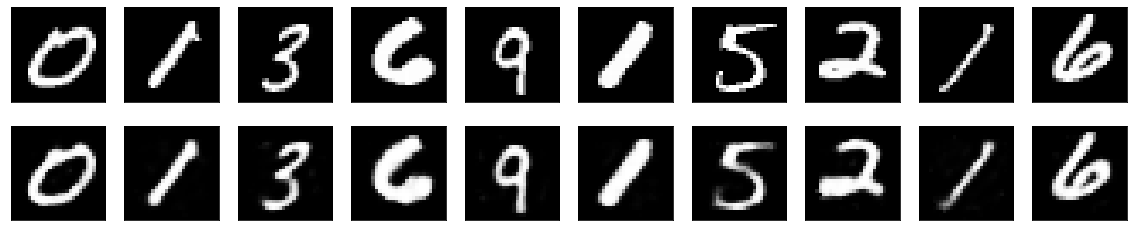

In [18]:
import matplotlib.pyplot as plt

n = 10 #number of images to plot
images_indeces = np.random.randint(low=0,high=10000,size=n)

plt.figure(figsize=(20, 4))

for (i,idx) in enumerate(images_indeces):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_test_hat[idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Quite good results!